In [1]:
# Change this to True for full dataset and learning
COMPLETE_RUN = True
data_path = '../data'

In [2]:
import numpy as np
np.random.seed(1001)

import os
import shutil
import warnings

# import IPython
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
matplotlib.style.use('ggplot')
warnings.filterwarnings("ignore", category=FutureWarning) 

In [3]:
os.listdir(data_path)

['train_curated',
 'sample_submission.csv',
 'train_noisy.csv',
 'compressed_files',
 'train_curated.csv',
 'test',
 'train_noisy']

In [4]:
data_path + "/train_curated.csv"

'../data/train_curated.csv'

In [5]:
train = pd.read_csv(data_path + "/train_curated.csv")
test = pd.read_csv(data_path + "/sample_submdission.csv")

In [6]:
train.sample(5)

fname                                             labels
1492  4de932d0.wav  Male_speech_and_man_speaking,Female_speech_and...
4727  f396ec97.wav                    Traffic_noise_and_roadway_noise
146   07dd3742.wav                                     Car_passing_by
3217  a6e6c971.wav                             Cutlery_and_silverware
4579  ecb1852a.wav                                       Male_singing

In [7]:
test.sample(5)

fname  Accelerating_and_revving_and_vroom  Accordion  \
134  07dff283.wav                                   0          0   
866  342cc3ae.wav                                   0          0   
180  0a64010f.wav                                   0          0   
185  0aee7a2a.wav                                   0          0   
901  3623b13a.wav                                   0          0   

     Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
134                0         0     0          0            0   
866                0         0     0          0            0   
180                0         0     0          0            0   
185                0         0     0          0            0   
901                0         0     0          0            0   

     Bathtub_(filling_or_washing)  Bicycle_bell        ...          \
134                             0             0        ...           
866                             0             0        ...           
180                             0             0        ...           
185                             0             0        ...           
901                             0             0        ...           

     Toilet_flush  Traffic_noise_and_roadway_noise  Trickle_and_dribble  \
134             0                                0                    0   
866             0                                0                    0   
180             0                                0                    0   
185             0                                0                    0   
901             0                                0                    0   

     Walk_and_footsteps  Water_tap_and_faucet  Waves_and_surf  Whispering  \
134                   0                     0               0           0   
866                   0                     0               0           0   
180                   0                     0               0           0   
185                   0                     0               0           0   
901                   0                     0               0           0   

     Writing  Yell  Zipper_(clothing)  
134        0     0                  0  
866        0     0                  0  
180        0     0                  0  
185        0     0                  0  
901        0     0                  0  

[5 rows x 81 columns]

In [8]:
print("Number of train examples=", train.shape[0], "  Number of classes=", len(set(train['labels'])))
print("Number of test examples=", test.shape[0], "  Number of classes=", len(set(test.columns[1:])))

Number of train examples= 4970   Number of classes= 213
Number of test examples= 1120   Number of classes= 80


- note that due to multi-labeld records in train, the number of unique classes is 213 (which is more than the test set's 80)
- For simplicity, we will exclude multi-labeled records in train, so the number of unique label is 74 ( < 80 ).
When buliding a valid model, we must consider this.

In [9]:
train = train[train['labels'].isin(test.columns[1:])]
print(len(train))

4269


In [62]:
(4970 - 4269) / 4970 # # We lose roughly 14% of our data set in order to make this simplification

0.14104627766599598

In [10]:
category_group = train.groupby(['labels']).count()
category_group.columns = ['counts']
print(len(category_group))

74


In [11]:
category_group.sample(5)

counts
labels                        
Squeak                      22
Burping_and_eructation      74
Finger_snapping             75
Meow                        59
Scissors                    75

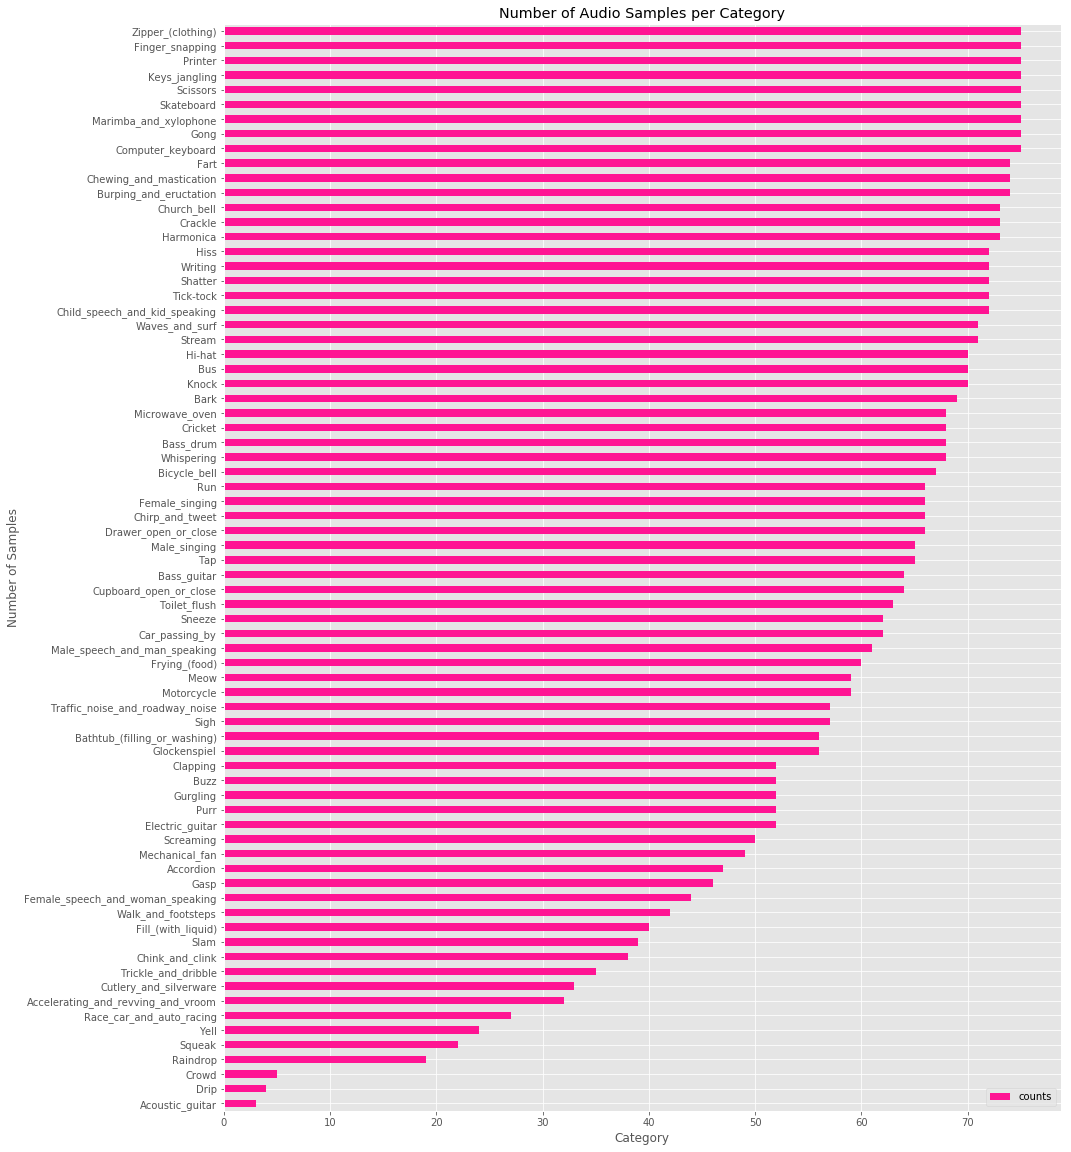

In [12]:
plot = category_group.sort_values(ascending=True, by='counts').plot(
    kind='barh', 
    title="Number of Audio Samples per Category", 
    color='deeppink', 
    figsize=(15,20))
plot.set_xlabel("Category")
plot.set_ylabel("Number of Samples");

In [13]:
print('Minimum samples per category = ', min(train['labels'].value_counts()))
print('Maximum samples per category = ', max(train['labels'].value_counts()))

Minimum samples per category =  3
Maximum samples per category =  75


Reading Audio Files

In [14]:
import IPython.display as ipd  # To play sound in the notebook
fname = data_path + '/train_curated/0019ef41.wav'   # Raindrop
ipd.Audio(fname)

In [15]:
# Using wave library
import wave

wav = wave.open(fname)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  90616
Duration =  2.054784580498866


- Bit-depth = 16: The amplitude of each sample in the audio is one of 2^16 (=65536) possible values.
- Samplig rate = 44.1 kHz: Each second in the audio consists of 44100 samples. So, if the duration of the audio file is 3.2 seconds, the audio will consist of 44100*3.2 = 141120 values.

In [16]:
# Using scipy
from scipy.io import wavfile
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (90616,)
[ 369 -577  -49 ...    0    0    0]


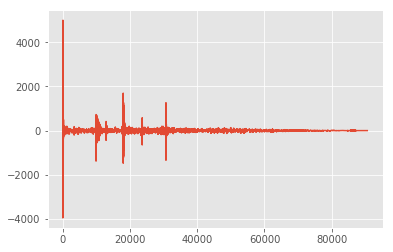

In [17]:
plt.plot(data, '-', );

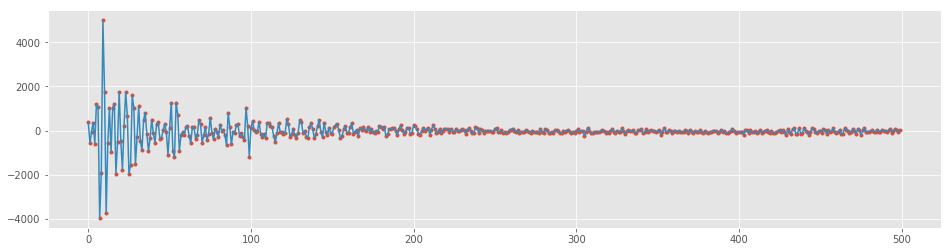

In [18]:
# Let's zoom in on first 1000 frames
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

Audio Length

In [19]:
train['nframes'] = train['fname'].apply(lambda f: wave.open(data_path + '/train_curated/' + f).getnframes())
test['nframes'] = test['fname'].apply(lambda f: wave.open(data_path + '/test/' + f).getnframes())

In [20]:
train.sample(5)

fname             labels  nframes
2107  6c6c57f2.wav  Computer_keyboard    56463
3479  b48baf55.wav            Writing   332552
2622  874adfa0.wav          Accordion    61972
1417  49cb6b39.wav               Slam    69096
1132  3ac1bcfe.wav           Scissors   202585

In [1]:
category_group.sort_values(ascending=True, by='counts').index[-25:]

NameError: name 'category_group' is not defined

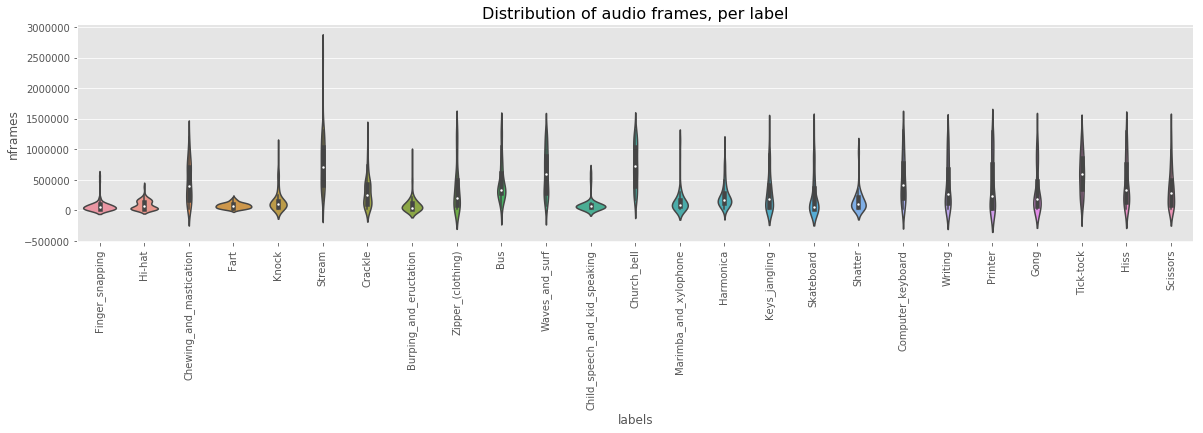

In [21]:
# The number of categories is large, so let's check the frame distributions of top 25 categories.

idx_sel = category_group.sort_values(ascending=True, by='counts').index[-25:]
_, ax = plt.subplots(figsize=(20, 4))
sns.violinplot(ax=ax, x="labels", y="nframes", data=train[(train['labels'].isin(idx_sel).values)])
plt.xticks(rotation=90)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()

We observe:  
The distribution of audio length across labels is non-uniform and has high variance as the previous competition.  

Let's now analyze the frame length distribution in train and test.  



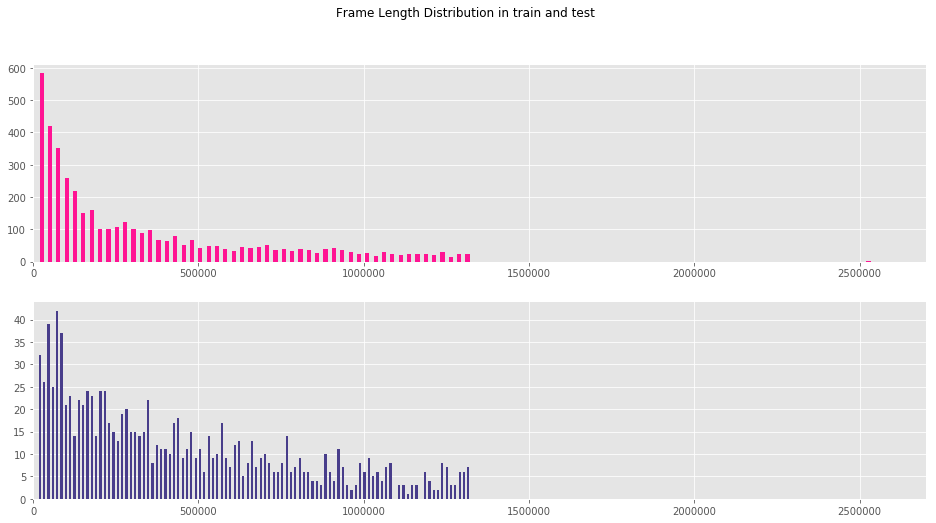

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(16,8))
train.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[0], color='deeppink')
test.nframes.hist(bins=100, grid=True, rwidth=0.5, ax=ax[1], color='darkslateblue')
ax[0].set_xlim(0, 2700000)
ax[1].set_xlim(0, 2700000)
plt.suptitle('Frame Length Distribution in train and test', ha='center', fontsize='large');

In [23]:
train.query("nframes > 2500000")

fname  labels  nframes
2316  77b925c2.wav  Stream  2538889

In [24]:
abnormal_length = 2538889

abnormal_fnames = train.loc[train.nframes == abnormal_length, 'fname'].values[0]
ipd.Audio(data_path + '/train_curated/' + abnormal_fnames)

## Building a Model using Raw Wave

In [25]:
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler, ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical

Using TensorFlow backend.


In [26]:
# The Configuration object stores those learning parameters that are shared
# between data generators models, and training functions. Anything that is
# global as far as the training is concerned can become the part of Configuration object.

class Config(object):
    def __init__(self,
                 sampling_rate=16000,
                 audio_duration=2, 
                 n_classes=len(category_group),
                 use_mfcc=False,
                 n_folds=10,
                 learning_rate=0.0001, 
                 max_epochs=50,
                 n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_foldsdarning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

In [27]:
# The DataGenerator class inherits from keras.utils.Sequence .
# It is useful for preprocessing and feeding the data to a Keras model.

# Note: Sequence are a safer way to do multiprocessing.
# This structure guarantees that the network will only train once on each
# sample per epoch which is not the case with generators.

class DataGenerator(Sequence):
    def __init__(self,
                 config,
                 data_dir,
                 list_IDs,
                 labels=None, 
                 batch_size=64,
                 preprocessing_fn=lambda x: x):
        self.config = config
        self.data_dir = data_dir
        self.list_IDs = list_IDs
        self.labels = labels
        self.batch_size = batch_size
        self.preprocessing_fn = preprocessing_fn
        self.on_epoch_end()
        self.dim = self.config.dim

    def __len__(self):
        # Once initialized with a batch_size, DataGenerator computes the number of batches in an epoch.
        # The __len__ method tells Keras how many batches to draw in each epoch.
        return int(np.ceil(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        # The __getitem__ method takes an index (which is the batch number) and
        # returns a batch of the data (both X and y) after calculating the offset.
        # During test time, only X is returned.
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        return self.__data_generation(list_IDs_temp)

    def on_epoch_end(self):
        # If we want to perform some action after each epoch (like shuffle the data,
        # or increase the proportion of augmented data), we can use the on_epoch_end method.
        self.indexes = np.arange(len(self.list_IDs))

    def __data_generation(self, list_IDs_temp):
        cur_batch_size = len(list_IDs_temp)
        X = np.empty((cur_batch_size, *self.dim))

        input_length = self.config.audio_length
        for i, ID in enumerate(list_IDs_temp):
            file_path = self.data_dir + ID
            
            # Read and Resample the audio
            data, _ = librosa.core.load(file_path, sr=self.config.sampling_rate, res_type='kaiser_fast')

            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                
            # Normalization + Other Preprocessing
            if self.config.use_mfcc:
                data = librosa.feature.mfcc(data, sr=self.config.sampling_rate, n_mfcc=self.config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
            else:
                data = self.preprocessing_fn(data)[:, np.newaxis]
            X[i,] = data

        if self.labels is not None:
            y = np.empty(cur_batch_size, dtype=int)
            for i, ID in enumerate(list_IDs_temp):
                y[i] = self.labels[ID]
            return X, to_categorical(y, num_classes=self.config.n_classes)
        else:
            return X

In [28]:
# Normalization is a crucial preprocessing step.
# The simplest method is rescaling the range of features to scale the range in [0, 1].

def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data - 0.5

In [29]:
# The dummy model is just for debugging purpose.

def get_1d_dummy_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = GlobalMaxPool1D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [30]:
# Our 1D Conv model is fairly deep and is trained
# using Adam Optimizer with a learning rate of 0.0001

def get_1d_conv_model(config):
    
    nclass = config.n_classes
    input_length = config.audio_length
    
    inp = Input(shape=(input_length,1))
    x = Convolution1D(16, 9, activation=relu, padding="valid")(inp)
    x = Convolution1D(16, 9, activation=relu, padding="valid")(x)
    x = MaxPool1D(16)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(32, 3, activation=relu, padding="valid")(x)
    x = MaxPool1D(4)(x)
    x = Dropout(rate=0.1)(x)
    
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = Convolution1D(256, 3, activation=relu, padding="valid")(x)
    x = GlobalMaxPool1D()(x)
    x = Dropout(rate=0.2)(x)

    x = Dense(64, activation=relu)(x)
    x = Dense(1028, activation=relu)(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [31]:
# It is important to convert raw labels to integer indices
train.head()

fname           labels  nframes
0  0006ae4e.wav             Bark   310456
1  0019ef41.wav         Raindrop    90616
2  001ec0ad.wav  Finger_snapping    66976
3  0026c7cb.wav              Run  1125886
4  0026f116.wav  Finger_snapping    60638

In [32]:
LABELS = list(train['labels'].unique())
label_idx = {label: i for i, label in enumerate(LABELS)}

train.set_index("fname", inplace=True)
test.set_index("fname", inplace=True)

train["label_idx"] = train['labels'].apply(lambda x: label_idx[x])

if not COMPLETE_RUN:
    train = train[:2000]
    test = test[:2000]

In [33]:
# raw labels with integer indices
train.head()

labels  nframes  label_idx
fname                                            
0006ae4e.wav             Bark   310456          0
0019ef41.wav         Raindrop    90616          1
001ec0ad.wav  Finger_snapping    66976          2
0026c7cb.wav              Run  1125886          3
0026f116.wav  Finger_snapping    60638          2

10-Fold Training

In [34]:
config = Config(sampling_rate=16000, audio_duration=2, n_folds=10, learning_rate=0.001)

if not COMPLETE_RUN:
    config = Config(sampling_rate=100, audio_duration=1, n_folds=2, max_epochs=1)

In [35]:
PREDICTION_FOLDER = "predictions_1d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

# We use from sklearn.model_selection.StratifiedKFold for splitting the trainig data into 10 folds.
skf = StratifiedKFold(n_splits=config.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    train_set = train.iloc[train_split]
    val_set = train.iloc[val_split]
    
    # We use some Keras callbacks to monitor the training.
    # ModelCheckpoint saves the best weight of our model (using validation data).
    # We use this weight to make test predictions.
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    # EarlyStopping stops the training once validation loss ceases to decrease
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    # TensorBoard helps us visualize training and validation loss and accuracy.
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%d'%i, write_graph=True)

    callbacks_list = [checkpoint, early, tb]
    print("\nFold: ", i)
    if COMPLETE_RUN:
        model = get_1d_conv_model(config)
    else:
        model = get_1d_dummy_model(config)

    # We fit the model using DataGenerator for training and validation splits.
    train_generator = DataGenerator(config, data_path + '/train_curated/', train_set.index, 
                                    train_set.label_idx, batch_size=64,
                                    preprocessing_fn=audio_norm)
    val_generator = DataGenerator(config, data_path + '/train_curated/', val_set.index, 
                                  val_set.label_idx, batch_size=64,
                                  preprocessing_fn=audio_norm)
    
    history = model.fit_generator(train_generator, callbacks=callbacks_list, validation_data=val_generator,
                                  epochs=config.max_epochs, use_multiprocessing=True, max_queue_size=20)
    
#     model.load_weights('../working/best_%d.h5'%i)
    
    # Save train predictions
    train_generator = DataGenerator(config, data_path + '/train_curated/', train.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(train_generator, use_multiprocessing=True, 
                                          max_queue_size=20, verbose=1)
    
    # We get both training and test predictions and save them as .npy format.
    # We also generate a submission file. For 10-fold CV, the number of prediction files should be 10.
    # We will ensemble these predictions later.
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)
    
    # Save test predictions
    test_generator = DataGenerator(config, data_path + '/test/', test.index, batch_size=128,
                                    preprocessing_fn=audio_norm)
    predictions = model.predict_generator(test_generator, use_multiprocessing=True, 
                                          max_queue_size=20, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)
    
    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



Fold:  0
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/50
60/60 [==============================] - 358s 6s/step - loss: 4.2295 - acc: 0.0162 - val_loss: 4.1340 - val_acc: 0.0389

Epoch 00001: val_loss improved from inf to 4.13403, saving model to best_0.h5
Epoch 2/50
60/60 [==============================] - 353s 6s/step - loss: 3.9883 - acc: 0.0378 - val_loss: 3.9007 - val_acc: 0.0410

Epoch 00002: val_loss improved from 4.13403 to 3.90075, saving model to best_0.h5
Epoch 3/50
60/60 [==============================] - 346s 6s/step - loss: 3.8414 - acc: 0.0399 - val_loss: 3.8352 - val_acc: 0.0562

Epoch 00003: val_loss improved from 3.90075 to 3.83523, saving model to best_0.h5
Epoch 4/50
60/60 [=====================

60/60 [==============================] - 349s 6s/step - loss: 1.8035 - acc: 0.4811 - val_loss: 2.3143 - val_acc: 0.4428

Epoch 00035: val_loss did not improve from 2.24331
Epoch 36/50
60/60 [==============================] - 342s 6s/step - loss: 1.8070 - acc: 0.4795 - val_loss: 2.2029 - val_acc: 0.4557

Epoch 00036: val_loss improved from 2.24331 to 2.20292, saving model to best_0.h5
Epoch 37/50
60/60 [==============================] - 347s 6s/step - loss: 1.7698 - acc: 0.4972 - val_loss: 2.1725 - val_acc: 0.4320

Epoch 00037: val_loss improved from 2.20292 to 2.17252, saving model to best_0.h5
Epoch 38/50
60/60 [==============================] - 346s 6s/step - loss: 1.7684 - acc: 0.4883 - val_loss: 2.2199 - val_acc: 0.4168

Epoch 00038: val_loss did not improve from 2.17252
Epoch 39/50
60/60 [==============================] - 350s 6s/step - loss: 1.6890 - acc: 0.5188 - val_loss: 2.2035 - val_acc: 0.4384

Epoch 00039: val_loss did not improve from 2.17252
Epoch 40/50
60/60 [===========

60/60 [==============================] - 341s 6s/step - loss: 1.9464 - acc: 0.4331 - val_loss: 2.4608 - val_acc: 0.3413

Epoch 00033: val_loss did not improve from 2.45805
Epoch 34/50
60/60 [==============================] - 344s 6s/step - loss: 1.8788 - acc: 0.4575 - val_loss: 2.3751 - val_acc: 0.3761

Epoch 00034: val_loss improved from 2.45805 to 2.37506, saving model to best_1.h5
Epoch 35/50
60/60 [==============================] - 343s 6s/step - loss: 1.8490 - acc: 0.4721 - val_loss: 2.4112 - val_acc: 0.3609

Epoch 00035: val_loss did not improve from 2.37506
Epoch 36/50
60/60 [==============================] - 346s 6s/step - loss: 1.8575 - acc: 0.4638 - val_loss: 2.4113 - val_acc: 0.3587

Epoch 00036: val_loss did not improve from 2.37506
Epoch 37/50
60/60 [==============================] - 340s 6s/step - loss: 1.8569 - acc: 0.4617 - val_loss: 2.4427 - val_acc: 0.3826

Epoch 00037: val_loss did not improve from 2.37506
Epoch 38/50
60/60 [==============================] - 347s 6s/

60/60 [==============================] - 348s 6s/step - loss: 2.2406 - acc: 0.3780 - val_loss: 2.3536 - val_acc: 0.3599

Epoch 00025: val_loss improved from 2.44643 to 2.35363, saving model to best_3.h5
Epoch 26/50
60/60 [==============================] - 342s 6s/step - loss: 2.1856 - acc: 0.3835 - val_loss: 2.4627 - val_acc: 0.3485

Epoch 00026: val_loss did not improve from 2.35363
Epoch 27/50
60/60 [==============================] - 346s 6s/step - loss: 2.1584 - acc: 0.3871 - val_loss: 2.4500 - val_acc: 0.3485

Epoch 00027: val_loss did not improve from 2.35363
Epoch 28/50
60/60 [==============================] - 346s 6s/step - loss: 2.1189 - acc: 0.4067 - val_loss: 2.2883 - val_acc: 0.3964

Epoch 00028: val_loss improved from 2.35363 to 2.28832, saving model to best_3.h5
Epoch 29/50
60/60 [==============================] - 351s 6s/step - loss: 2.0854 - acc: 0.4161 - val_loss: 2.2404 - val_acc: 0.4214

Epoch 00029: val_loss improved from 2.28832 to 2.24035, saving model to best_3.h5

61/61 [==============================] - 352s 6s/step - loss: 3.3035 - acc: 0.1437 - val_loss: 3.3350 - val_acc: 0.1077

Epoch 00007: val_loss improved from 3.38486 to 3.33498, saving model to best_5.h5
Epoch 8/50
61/61 [==============================] - 348s 6s/step - loss: 3.2284 - acc: 0.1462 - val_loss: 3.2502 - val_acc: 0.1483

Epoch 00008: val_loss improved from 3.33498 to 3.25018, saving model to best_5.h5
Epoch 9/50
61/61 [==============================] - 346s 6s/step - loss: 3.1625 - acc: 0.1613 - val_loss: 3.1445 - val_acc: 0.1699

Epoch 00009: val_loss improved from 3.25018 to 3.14446, saving model to best_5.h5
Epoch 10/50
61/61 [==============================] - 358s 6s/step - loss: 3.1101 - acc: 0.1788 - val_loss: 3.1164 - val_acc: 0.1746

Epoch 00010: val_loss improved from 3.14446 to 3.11640, saving model to best_5.h5
Epoch 11/50
61/61 [==============================] - 348s 6s/step - loss: 2.9972 - acc: 0.2072 - val_loss: 3.0019 - val_acc: 0.1962

Epoch 00011: val_loss

61/61 [==============================] - 352s 6s/step - loss: 1.8908 - acc: 0.4585 - val_loss: 2.0892 - val_acc: 0.4818

Epoch 00036: val_loss did not improve from 2.07874
Epoch 37/50
61/61 [==============================] - 348s 6s/step - loss: 1.8350 - acc: 0.4691 - val_loss: 2.1394 - val_acc: 0.4647

Epoch 00037: val_loss did not improve from 2.07874
Epoch 38/50
61/61 [==============================] - 348s 6s/step - loss: 1.8763 - acc: 0.4576 - val_loss: 2.0751 - val_acc: 0.4599

Epoch 00038: val_loss improved from 2.07874 to 2.07507, saving model to best_6.h5
Epoch 39/50
61/61 [==============================] - 349s 6s/step - loss: 1.8233 - acc: 0.4659 - val_loss: 2.1141 - val_acc: 0.4696

Epoch 00039: val_loss did not improve from 2.07507
Epoch 40/50
61/61 [==============================] - 348s 6s/step - loss: 1.7872 - acc: 0.4791 - val_loss: 2.0778 - val_acc: 0.4623

Epoch 00040: val_loss did not improve from 2.07507
Epoch 41/50
61/61 [==============================] - 353s 6s/

61/61 [==============================] - 344s 6s/step - loss: 2.2466 - acc: 0.3681 - val_loss: 2.3114 - val_acc: 0.3940

Epoch 00022: val_loss did not improve from 2.27592
Epoch 23/50
61/61 [==============================] - 350s 6s/step - loss: 2.2034 - acc: 0.3725 - val_loss: 2.3278 - val_acc: 0.3466

Epoch 00023: val_loss did not improve from 2.27592
Epoch 24/50
61/61 [==============================] - 347s 6s/step - loss: 2.1251 - acc: 0.3925 - val_loss: 2.2692 - val_acc: 0.4090

Epoch 00024: val_loss improved from 2.27592 to 2.26921, saving model to best_8.h5
Epoch 25/50
61/61 [==============================] - 349s 6s/step - loss: 2.1410 - acc: 0.3961 - val_loss: 2.2164 - val_acc: 0.4264

Epoch 00025: val_loss improved from 2.26921 to 2.21636, saving model to best_8.h5
Epoch 26/50
61/61 [==============================] - 353s 6s/step - loss: 2.1091 - acc: 0.4010 - val_loss: 2.1895 - val_acc: 0.4140

Epoch 00026: val_loss improved from 2.21636 to 2.18952, saving model to best_8.h5

In [36]:
# predictions are saved as following.
os.listdir('./predictions_1d_conv/')

['train_predictions_1.npy',
 'train_predictions_4.npy',
 'train_predictions_0.npy',
 'test_predictions_0.npy',
 'test_predictions_3.npy',
 'train_predictions_7.npy',
 'predictions_8.csv',
 'test_predictions_6.npy',
 'predictions_2.csv',
 'train_predictions_8.npy',
 'predictions_9.csv',
 'train_predictions_9.npy',
 'test_predictions_1.npy',
 'test_predictions_5.npy',
 'predictions_0.csv',
 'predictions_6.csv',
 'test_predictions_8.npy',
 'predictions_4.csv',
 'train_predictions_3.npy',
 'train_predictions_5.npy',
 'predictions_3.csv',
 'test_predictions_7.npy',
 'predictions_1.csv',
 'predictions_7.csv',
 'test_predictions_2.npy',
 'test_predictions_9.npy',
 'test_predictions_4.npy',
 'train_predictions_2.npy',
 'predictions_5.csv',
 'train_predictions_6.npy']

In [37]:
# Ensembling 1D Conv Predictions
# Now that we have trained our model, it is time average the predictions of X-folds.
# We will try Geometric Mean averaging.

pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load("./predictions_1d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])

# calculate geometric mean
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))

# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv(data_path + '/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("1d_conv_ensembled_submission.csv", index=False)

## Adding MFCC to the Model

In [38]:
# The library librosa has a function to calculate MFCC. Let's compute the MFCC of an audio file and visualize it.

SAMPLE_RATE = 44100
fname = data_path + '/train_curated/0019ef41.wav'  # Raindrop
wav, _ = librosa.core.load(fname, sr=SAMPLE_RATE)
wav = wav[:2*44100]

In [39]:
mfcc = librosa.feature.mfcc(wav, sr = SAMPLE_RATE, n_mfcc=40)
mfcc.shape

(40, 173)

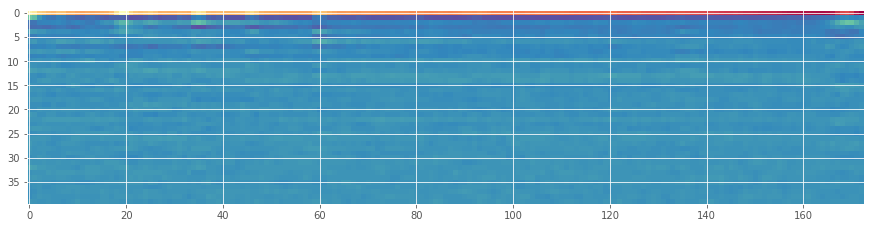

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.imshow(mfcc, cmap='Spectral', interpolation='nearest');

We will build a 2D Convolutional model using MFCC

In [41]:
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

In [42]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (4,10), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(32, (4,10), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

prep the data

In [43]:
config = Config(sampling_rate=44100, audio_duration=2, n_folds=10, 
                learning_rate=0.001, use_mfcc=True, n_mfcc=40)
if not COMPLETE_RUN:
    config = Config(sampling_rate=44100, audio_duration=2, n_folds=2, 
                    max_epochs=1, use_mfcc=True, n_mfcc=40)

In [44]:
def prepare_data(df, config, data_dir):
    X = np.empty(shape=(df.shape[0], config.dim[0], config.dim[1], 1))
    input_length = config.audio_length
    for i, fname in enumerate(df.index):
#         print(fname)
        file_path = data_dir + fname
        data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")

        # Random offset / Padding
        if len(data) > input_length:
            max_offset = len(data) - input_length
            offset = np.random.randint(max_offset)
            data = data[offset:(input_length+offset)]
        else:
            if input_length > len(data):
                max_offset = input_length - len(data)
                offset = np.random.randint(max_offset)
            else:
                offset = 0
            data = np.pad(data, (offset, input_length - len(data) - offset), "constant")

        data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
        data = np.expand_dims(data, axis=-1)
        X[i,] = data
    return X

In [45]:
test.sample()

fname  Accelerating_and_revving_and_vroom  Accordion  \
141  081f2b5a.wav                                   0          0   

     Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
141                0         0     0          0            0   

     Bathtub_(filling_or_washing)  Bicycle_bell  \
141                             0             0   

                       ...                     \
141                    ...                      

     Traffic_noise_and_roadway_noise  Trickle_and_dribble  Walk_and_footsteps  \
141                                0                    0                   0   

     Water_tap_and_faucet  Waves_and_surf  Whispering  Writing  Yell  \
141                     0               0           0        0     0   

     Zipper_(clothing)                                     label  
141                  0  Bass_guitar Zipper_(clothing) Motorcycle  

[1 rows x 82 columns]

In [46]:
test.index = test.fname

In [47]:
test.sample()

fname  Accelerating_and_revving_and_vroom  Accordion  \
fname                                                                       
03754ab4.wav  03754ab4.wav                                   0          0   

              Acoustic_guitar  Applause  Bark  Bass_drum  Bass_guitar  \
fname                                                                   
03754ab4.wav                0         0     0          0            0   

              Bathtub_(filling_or_washing)  Bicycle_bell  \
fname                                                      
03754ab4.wav                             0             0   

                                    ...                          \
fname                               ...                           
03754ab4.wav                        ...                           

              Traffic_noise_and_roadway_noise  Trickle_and_dribble  \
fname                                                                
03754ab4.wav                                0                    0   

              Walk_and_footsteps  Water_tap_and_faucet  Waves_and_surf  \
fname                                                                    
03754ab4.wav                   0                     0               0   

              Whispering  Writing  Yell  Zipper_(clothing)  \
fname                                                        
03754ab4.wav           0        0     0                  0   

                                                          label  
fname                                                            
03754ab4.wav  Toilet_flush Frying_(food) Bathtub_(filling_or...  

[1 rows x 82 columns]

In [48]:
%time
X_train = prepare_data(train, config, data_path + '/train_curated/')
X_test = prepare_data(test, config, data_path + '/test/')
y_train = to_categorical(train.label_idx.astype('str'), num_classes=config.n_classes)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [49]:
# Normalize data

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [50]:
# Training 2D Conv on MFCC

PREDICTION_FOLDER = "predictions_2d_conv"
if not os.path.exists(PREDICTION_FOLDER):
    os.mkdir(PREDICTION_FOLDER)
if os.path.exists('logs/' + PREDICTION_FOLDER):
    shutil.rmtree('logs/' + PREDICTION_FOLDER)

skf = StratifiedKFold(n_splits=config.n_folds)

for i, (train_split, val_split) in enumerate(skf.split(train.index, train.label_idx)):
    K.clear_session()
    X, y, X_val, y_val = X_train[train_split], y_train[train_split], X_train[val_split], y_train[val_split]
    checkpoint = ModelCheckpoint('best_%d.h5'%i, monitor='val_loss', verbose=1, save_best_only=True)
    early = EarlyStopping(monitor="val_loss", mode="min", patience=5)
    tb = TensorBoard(log_dir='./logs/' + PREDICTION_FOLDER + '/fold_%i'%i, write_graph=True)
    callbacks_list = [checkpoint, early, tb]
    print("#"*50)
    print("Fold: ", i)
    model = get_2d_conv_model(config)
    history = model.fit(X, y, validation_data=(X_val, y_val), callbacks=callbacks_list, 
                        batch_size=64, epochs=config.max_epochs)
    model.load_weights('best_%d.h5'%i)

    # Save train predictions
    predictions = model.predict(X_train, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/train_predictions_%d.npy"%i, predictions)

    # Save test predictions
    predictions = model.predict(X_test, batch_size=64, verbose=1)
    np.save(PREDICTION_FOLDER + "/test_predictions_%d.npy"%i, predictions)

    # Make a submission file
    top_3 = np.array(LABELS)[np.argsort(-predictions, axis=1)[:, :3]]
    predicted_labels = [' '.join(list(x)) for x in top_3]
    test['label'] = predicted_labels
    test[['label']].to_csv(PREDICTION_FOLDER + "/predictions_%d.csv"%i)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


##################################################
Fold:  0
Train on 3806 samples, validate on 463 samples
Epoch 1/50
3806/3806 [==============================] - 111s 29ms/step - loss: 4.0444 - acc: 0.0783 - val_loss: 3.7718 - val_acc: 0.1123

Epoch 00001: val_loss improved from inf to 3.77179, saving model to best_0.h5
Epoch 2/50
3806/3806 [==============================] - 103s 27ms/step - loss: 3.5269 - acc: 0.1726 - val_loss: 3.5694 - val_acc: 0.1598

Epoch 00002: val_loss improved from 3.77179 to 3.56945, saving model to best_0.h5
Epoch 3/50
3806/3806 [==============================] - 103s 27ms/step - loss: 3.1343 - acc: 0.2633 - val_loss: 3.2628 - val_acc: 0.2073

Epoch 00003: val_loss improved from 3.56945 to 3.26284, saving model to best_0.h5
Epoch 4/50
3806/3806 [==============================] - 103s 27ms/step - loss: 2.8187 - acc: 0.3463 - val_loss: 3.0653 - val_acc: 0.2570

Epoch 00004: val_loss improved from 3.26284 to 3.06525, saving model to best_0.h5
Epoch 5/50
3806/3

3838/3838 [==============================] - 104s 27ms/step - loss: 0.5023 - acc: 0.9297 - val_loss: 2.7046 - val_acc: 0.3550

Epoch 00014: val_loss did not improve from 2.61315
Epoch 15/50
3838/3838 [==============================] - 104s 27ms/step - loss: 0.3582 - acc: 0.9591 - val_loss: 2.7203 - val_acc: 0.3341

Epoch 00015: val_loss did not improve from 2.61315
Epoch 16/50
3838/3838 [==============================] - 104s 27ms/step - loss: 0.2525 - acc: 0.9799 - val_loss: 2.7809 - val_acc: 0.3480

Epoch 00016: val_loss did not improve from 2.61315
Epoch 17/50
3838/3838 [==============================] - 104s 27ms/step - loss: 0.1759 - acc: 0.9885 - val_loss: 2.6582 - val_acc: 0.3712

Epoch 00017: val_loss did not improve from 2.61315
Epoch 18/50
3838/3838 [==============================] - 104s 27ms/step - loss: 0.1210 - acc: 0.9937 - val_loss: 2.7387 - val_acc: 0.3503

Epoch 00018: val_loss did not improve from 2.61315
1120/1120 [==============================] - 8s 7ms/step
#####

3874/3874 [==============================] - 105s 27ms/step - loss: 1.4262 - acc: 0.6662 - val_loss: 2.6800 - val_acc: 0.3696

Epoch 00010: val_loss improved from 2.74001 to 2.67996, saving model to best_9.h5
Epoch 11/50
3874/3874 [==============================] - 104s 27ms/step - loss: 1.2410 - acc: 0.7171 - val_loss: 2.6103 - val_acc: 0.3722

Epoch 00011: val_loss improved from 2.67996 to 2.61029, saving model to best_9.h5
Epoch 12/50
3874/3874 [==============================] - 105s 27ms/step - loss: 1.0336 - acc: 0.7819 - val_loss: 2.5428 - val_acc: 0.3772

Epoch 00012: val_loss improved from 2.61029 to 2.54277, saving model to best_9.h5
Epoch 13/50
3874/3874 [==============================] - 104s 27ms/step - loss: 0.8795 - acc: 0.8198 - val_loss: 2.7279 - val_acc: 0.3291

Epoch 00013: val_loss did not improve from 2.54277
Epoch 14/50
3874/3874 [==============================] - 105s 27ms/step - loss: 0.6848 - acc: 0.8758 - val_loss: 2.7843 - val_acc: 0.3241

Epoch 00014: val_los

In [60]:
# Ensembling 2D Conv Predictions¶

pred_list = []
for i in range(config.n_folds):
    pred_list.append(np.load("./predictions_2d_conv/test_predictions_%d.npy"%i))
prediction = np.ones_like(pred_list[0])
for pred in pred_list:
    prediction = prediction*pred
prediction = prediction**(1./len(pred_list))
# Make a submission file
top_3 = np.array(LABELS)[np.argsort(-prediction, axis=1)[:, :3]]
predicted_labels = [' '.join(list(x)) for x in top_3]
test = pd.read_csv(data_path + '/sample_submission.csv')
test['label'] = predicted_labels
test[['fname', 'label']].to_csv("2d_conv_ensembled_submission.csv", index=False)

Next Steps:

Mel-Spectogram?  
L2 Regularization  
Add model complexity graphs? (epoch over error for train/test line graph)  
tanh (hyperbolic tangent) activations?  
stochastic gradient descent? via SGD optimizer  
decaying learning rates?  
momentum  